In [1]:
import sys
sys.path.append("..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from scipy.stats import boxcox, ttest_ind
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
# from modeldb.sklearn_native import CrossValidationScore
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from coh_tools import *
%matplotlib inline

In [2]:
import matplotlib.style as style

In [3]:
style.available

['seaborn-paper',
 'Solarize_Light2',
 'seaborn-whitegrid',
 'fivethirtyeight',
 '_classic_test',
 'seaborn-white',
 'seaborn-bright',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-notebook',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-pastel',
 'tableau-colorblind10',
 'seaborn-talk',
 'seaborn-poster',
 'grayscale',
 'bmh',
 'dark_background',
 'fast',
 'seaborn-ticks',
 'seaborn-muted',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn']

In [4]:
# style.use("seaborn-white")
style.use('tableau-colorblind10')

In [5]:
# Get experiment info
os.chdir("/home/julien/school/lab/oe_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pd.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]

In [6]:
experiments

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0    Experiment1  MonkeyG  20150908  Session2     M1   
1    Experiment2  MonkeyG  20150908  Session3     M1   
2    Experiment3  MonkeyG  20150908  Session4     M1   
3    Experiment4  MonkeyG  20150909  Session2     M1   
4    Experiment5  MonkeyG  20150909  Session3     M1   
..           ...      ...       ...       ...    ...   
64  Experiment65  MonkeyJ  20160627  Session2     S1   
65  Experiment66  MonkeyJ  20160630  Session1     S1   
66  Experiment67  MonkeyJ  20160630  Session3     S1   
67  Experiment68  MonkeyJ  20160702  Session2     S1   
68  Experiment69  MonkeyJ  20160702  Session4     S1   

                           File Name  stim_Coh_from  stim_Coh_to  \
0   MonkeyG_20150908_Session2_M1.zip             46           63   
1   MonkeyG_20150908_Session3_M1.zip             48           43   
2   MonkeyG_20150908_Session4_M1.zip             48           16   
3   MonkeyG_20150909_Session2_M1.zip             48           12   
4   MonkeyG_20150909_Session3_M1.zip             53           27   
..                               ...            ...          ...   
64  MonkeyJ_20160627_Session2_S1.zip             39           14   
65  MonkeyJ_20160630_Session1_S1.zip             62           55   
66  MonkeyJ_20160630_Session3_S1.zip             58           63   
67  MonkeyJ_20160702_Session2_S1.zip             50           37   
68  MonkeyJ_20160702_Session4_S1.zip             44           64   

    Number of Lasers in Experiment  Number of Lasers during Conditioning  \
0                                2                                     2   
1                                2                                     2   
2                                2                                     2   
3                                2                                     2   
4                                2                                     2   
..                             ...                                   ...   
64                               2                                     2   
65                               2                                     2   
66                               2                                     2   
67                               2                                     2   
68                               2                                     2   

    Delay                       keyname   one   two  doubles  singles  
0    10ms  MonkeyG_20150908_Session2_M1  True  True     True    False  
1    10ms  MonkeyG_20150908_Session3_M1  True  True     True    False  
2    10ms  MonkeyG_20150908_Session4_M1  True  True     True    False  
3    10ms  MonkeyG_20150909_Session2_M1  True  True     True    False  
4    10ms  MonkeyG_20150909_Session3_M1  True  True     True    False  
..    ...                           ...   ...   ...      ...      ...  
64  100ms  MonkeyJ_20160627_Session2_S1  True  True     True    False  
65  100ms  MonkeyJ_20160630_Session1_S1  True  True     True    False  
66   10ms  MonkeyJ_20160630_Session3_S1  True  True     True    False  
67   10ms  MonkeyJ_20160702_Session2_S1  True  True     True    False  
68  100ms  MonkeyJ_20160702_Session4_S1  True  True     True    False  

[69 rows x 16 columns]

In [7]:
multiband_paired_dict = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/multiband_timefreq_paired_dict.pkl", "rb"))
# multiband_paired_dict = pkl.load(open(r"C:\Users\julienb\lab\oe_data_analysis\pickled\multiband_timefreq_paired_dict.pkl", "rb"))
# multiband_allcon_dict = pkl.load(open("/mnt/hdd2tb/lab/elife/data/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_paired_phase_dict = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/multiband_timefreq_paired_phase_dict.pkl", "rb"))


In [8]:
# multiband_paired_dict['beta']

In [9]:
ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = "/home/julien/school/lab/oe_data_analysis/csvs/")
# ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = r"C:\Users\julienb\lab\oe_data_analysis\csvs/")

def get_distance(electrode_a, electrode_b): # Indexing is 1 - 96
    if min(electrode_a, electrode_b) <= 0:
        print("Electrode indexing starts from 1")
        return
    return ((ecog_map[0][electrode_a-1]  - ecog_map[0][electrode_b-1])**2 + (ecog_map[1][electrode_a-1]  - ecog_map[1][electrode_b-1])**2)**.5


## Analyze all blocks of recordings

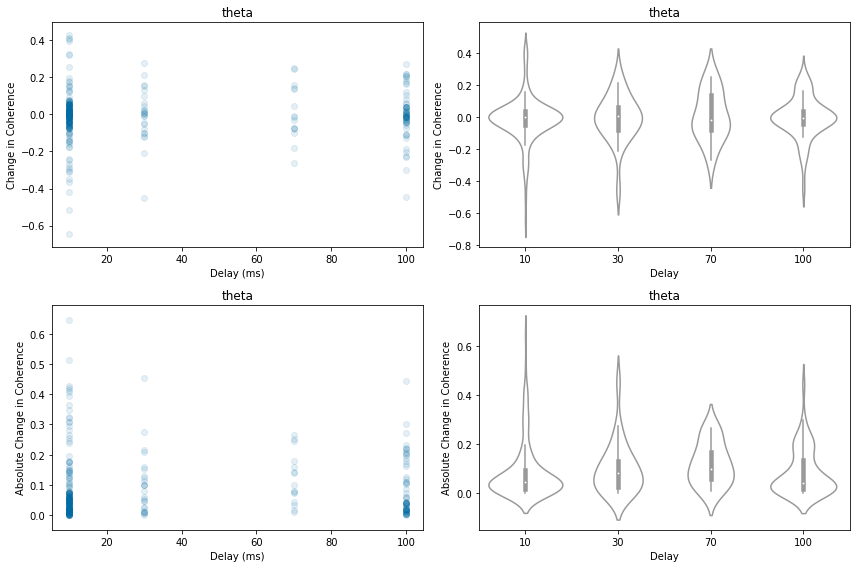

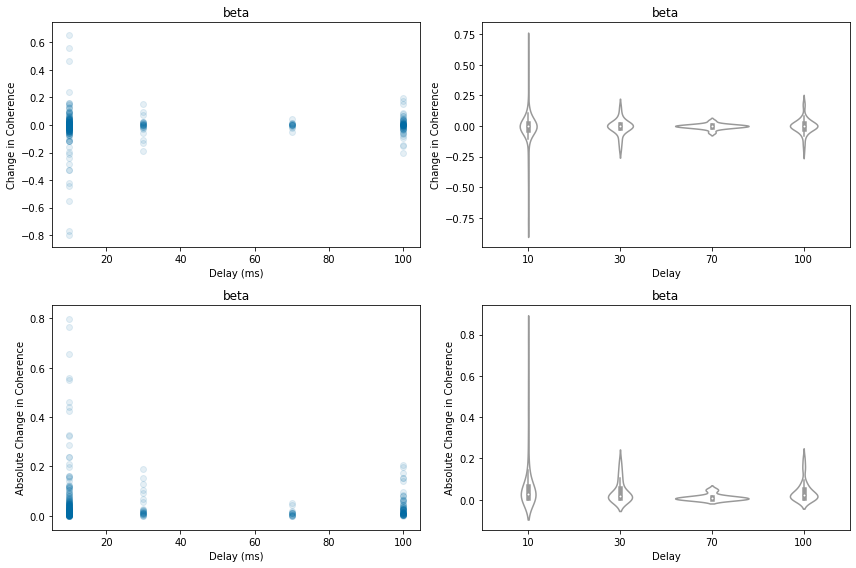

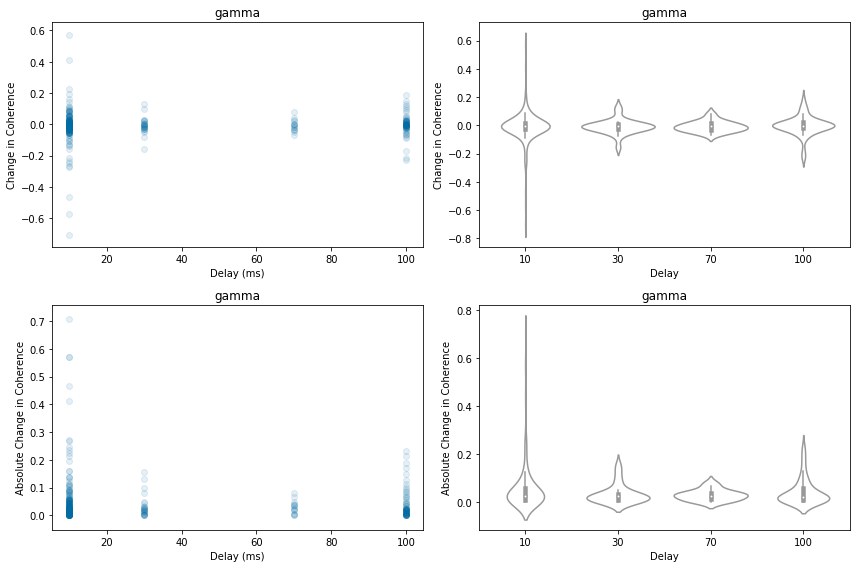

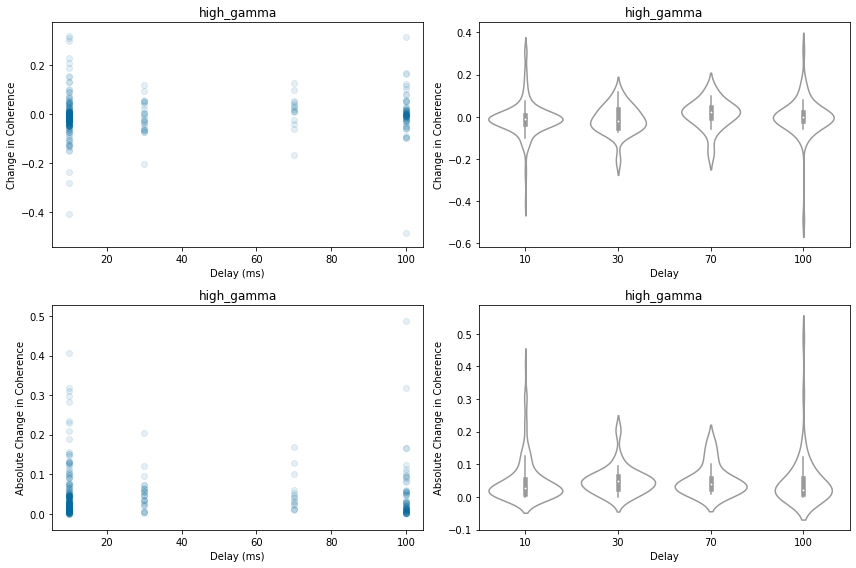

In [10]:
## Generate plots ##
for band in ["theta", "beta", "gamma", "high_gamma"]:
    paired_dict = multiband_paired_dict[band]

    basemeans = []
    newbasemeans = []
    delays = []
    deltacohs = []
    exp_list = []

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_list.append(key[:25])

        try:
            for block_num in np.arange(6)+1:
                rec_key = key+"_RecBlock"+str(block_num)
                
                if block_num < 6:
                    basemeans.append(paired_dict[rec_key].mean())
                if block_num > 1:
                    newbasemeans.append(paired_dict[rec_key].mean())
                    delays.append(int(row["Delay"][:-2]))

        except:
            continue

    plt.subplots(figsize=(12,8))
    
    Y = np.array(newbasemeans) - np.array(basemeans) 
    plt.subplot(221)
    plt.scatter(delays, Y, alpha=.1)
    plt.title(band) #, color="white")
    plt.xlabel("Delay (ms)")
    plt.ylabel("Change in Coherence")
#     plt.show()
    
    plt.subplot(222)
    df = pd.DataFrame(list(zip(delays, Y)))
    sns.violinplot(x=0, y=1, data=df, color="white")
    plt.title(band)
    plt.xlabel("Delay")
    plt.ylabel("Change in Coherence")
#     plt.show()
    
#     print("Absolute:")
    Y = abs(Y)
    plt.subplot(223)
    plt.scatter(delays, Y, alpha=.1)
    plt.title(band) #, color="white")
    plt.xlabel("Delay (ms)")
    plt.ylabel("Absolute Change in Coherence")
#     plt.show()
    
    plt.subplot(224)
    df = pd.DataFrame(list(zip(delays, Y)))
    sns.violinplot(x=0, y=1, data=df, color="white")
    plt.title(band)
    plt.xlabel("Delay")
    plt.ylabel("Absolute Change in Coherence")
    plt.tight_layout()
    plt.show()
    
#     Y = abs(np.array(newbasemeans) - np.array(basemeans))
#     tau = 10
#     delay_curve = np.exp(-np.array(delays)/tau)
    
#     X = delay_curve
#     X = pd.DataFrame({"Delay (STDP Curve transformed)": delay_curve, "Delay (true value)": delays})
#     stdp_ols = sm.OLS(Y, sm.add_constant(X)).fit()
#     print(stdp_ols.summary())


theta
beta
gamma
high_gamma


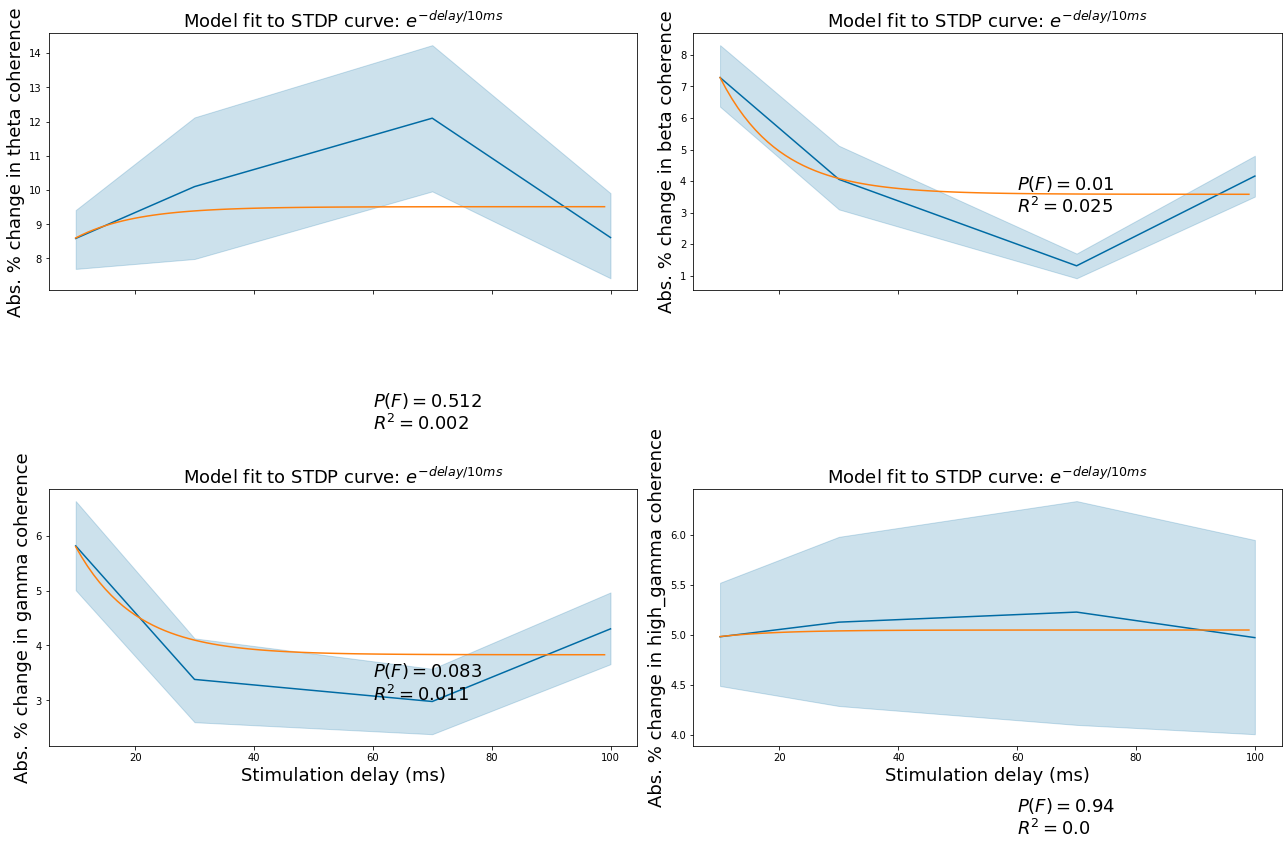

In [16]:
## Do Stats ##
fig, axs = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
for band_i, band in enumerate(["theta", "beta", "gamma", "high_gamma"]):
# for band in ["gamma"]:

    print(band)
    p_values = []

    paired_dict = multiband_paired_dict[band]
    paired_phase_dict = multiband_paired_phase_dict[band]
    
    initialphase_sign = []
    phasemeans = []
    newphasemeans = []
    basemeans = []
    newbasemeans = []
    delays = []
    deltacohs = []
    distances = []
    exp_list = []

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]

        exp_list.append(key[:25])

        try:
            for block_num in np.arange(6)+1:
                rec_key = key+"_RecBlock"+str(block_num)

                if block_num < 6:
                    basemeans.append(paired_dict[rec_key].mean())
                    phasemeans.append(paired_phase_dict[rec_key].mean())
                if block_num > 1:
                    newbasemeans.append(paired_dict[rec_key].mean())
                    newphasemeans.append(paired_phase_dict[rec_key].mean())
                    delays.append(int(row["Delay"][:-2]))
                    electrode_a = row["stim_Coh_from"]
                    electrode_b = row["stim_Coh_to"]
                    distance = get_distance(electrode_a, electrode_b)
                    distances.append(distance)
                if block_num == 1:
                    initialphase_sign.append(np.repeat(np.sign(paired_phase_dict[rec_key].mean()), 5))


        except:
            continue

    initialphase_sign = np.asarray(np.concatenate(initialphase_sign)).flatten()

    Y = (np.array(newbasemeans) - np.array(basemeans)) #/ np.array(basemeans)
    Y_abs = abs(Y)
#     Y_abs = 
    phase_change = np.array(newphasemeans) - np.array(phasemeans)
    data = pd.DataFrame({"Delay_true": delays, "Initial_coh": basemeans, "Initial_phase_sign": initialphase_sign, \
                         "Distance": distances, "Y_abs": Y_abs*100, "Y": Y, "Y_percent": Y*100, \
                         "phase_change": phase_change, "phase":phasemeans})
    data["Initial_phase_sign_str"] = data["Initial_phase_sign"].map({-1: "Negative phase", 1: "Positive phase"})
    data["phase_delay"] = -data[["Delay_true", "Initial_phase_sign"]].product(axis=1)
    

    
#         scaler = StandardScaler()
#         data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
#         data_scaled["Y"] = Y

#         print("for linear:")
#         print(normal_delay.rsquared)

    for tau in [10]:
        delay_curve = np.exp(-(np.array(delays))/tau)

        data["Delay_STDP"] = delay_curve

#             scaler = StandardScaler()
#             data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
#             data_scaled["Y"] = Y

        stdp_delay = smf.ols(formula='Y_abs ~  Delay_STDP', data=data).fit()
#             print("for tau = "+str(tau))
#             print(stdp_delay.rsquared)
    normal_delay = smf.ols(formula='Y_abs ~  Delay_true', data=data).fit()

        ## Remove uncertain phases ##
#     data = data[abs(data.phase) > .01]

#     print(normal_delay.summary())
#     print(stdp_delay.summary())

    pos_group = data.where(data.Initial_phase_sign== 1).dropna()['Y']
    neg_group = data.where(data.Initial_phase_sign== -1).dropna()['Y']
    ttest_result = ttest_ind(pos_group, neg_group)

    if ttest_result.pvalue < .001:
        stdp_asterisks = "***"
    elif ttest_result.pvalue < .01:
        stdp_asterisks = "**"
    elif ttest_result.pvalue < .05:
        stdp_asterisks = "*"
    else:
        stdp_asterisks = ""

#     if normal_delay.f_pvalue < .001:
#         normal_asterisks = "***"
#     elif normal_delay.f_pvalue < .01:
#         normal_asterisks = "**"
#     elif normal_delay.f_pvalue < .05:
#         normal_asterisks = "*"
#     else:
#         normal_asterisks = ""

    ### PLOTTING ###
    b = sns.relplot(x="Delay_true", y="Y_abs", data=data, kind="line", label="Data", ci=68, height=8.27, aspect=11.7/8.27, ax=axs[band_i//2, band_i%2])
#         b.tick_params(labelsize=16)
    b.axes[0,0].set_xlim(0,)
#     plt.plot([], [])
    axs[band_i//2, band_i%2].plot([], [])
    axs[band_i//2, band_i%2].plot(np.arange(10, 100), stdp_delay.predict(pd.DataFrame({"Delay_STDP": np.exp(-np.array(np.arange(10, 100))/tau)})), label="Scaled STDP Curve") #, color="blue")
    axs[band_i//2, band_i%2].set_ylabel("Abs. % change in "+ band +" coherence", fontsize=18)
    axs[band_i//2, band_i%2].set_xlabel("Stimulation delay (ms)", fontsize=18)
#         plt.yscale("log")
    axs[band_i//2, band_i%2].text(60, 3, r'$P(F)=$'+str(round(stdp_delay.f_pvalue, 3))+stdp_asterisks+"\n"+r'$R^2=$'+str(round(stdp_delay.rsquared, 3)), fontsize=18)
    axs[band_i//2, band_i%2].set_title("Model fit to STDP curve: "+r'$e^{-delay/10ms}$', fontsize=18)
#     plt.plot([], [])
#     plt.savefig("/home/julien/school/lab/oe_data_analysis/figures/stdp/STDP_"+band+".pdf")

#     plt.plot(np.arange(10, 100), normal_delay.predict(pd.DataFrame({"Delay_true": np.arange(10, 100)})), label="Best fit line")#, color="green")
#         plt.text(60, 2, r'$P(F)=$'+str(round(normal_delay.f_pvalue, 3))+normal_asterisks+"\n"+r'$R^2=$'+str(round(normal_delay.rsquared, 3)), fontsize=18)
    
#     # Plot phase STDP plot
#     rp = sns.relplot(x="phase_delay", y="Y", data=data, hue="Initial_phase_sign_str", kind="line", ci=68)
#     rp.fig.suptitle(band)
# #     plt.show()
#     plt.savefig("/home/julien/school/lab/oe_data_analysis/figures/stdp/STDP_withphase_"+band+".pdf")
#     plt.close()
#     pp = sns.pointplot(x="Initial_phase_sign_str", y="Y", data=data, hue="Initial_phase_sign_str", order=["Positive phase", "Negative phase"], hue_order=["Positive phase", "Negative phase"], ci=68)
#     pp.legend_.remove()
#     pp.set_title(band+"\np: "+str(round(ttest_result.pvalue, 4)))
# #     Distance plot
# #     sns.relplot(x="Distance", y="Y", data=data, hue="Delay_true", kind="line", ci=68)
#     plt.savefig("/home/julien/school/lab/oe_data_analysis/figures/stdp/STDP_stats_withphase_"+band+".pdf")
#     plt.close()

#     plt.legend()
    plt.close(b.fig)
plt.tight_layout()
# plt.savefig("/home/julien/school/lab/oe_data_analysis/figures/stdp/STDP_allbands.pdf")
#     plt.show()

# #         plt.savefig(r"C:\Users\julienb\lab\oe_data_analysis\figures\stdp"+'/STDP_gamma.eps', format="eps")
# #         print()
    

In [12]:
data[abs(data.phase) > .01]

Delay_true  Initial_coh  Initial_phase_sign  Distance      Y_abs  \
0            10     0.176822                 1.0  5.830952  10.389595   
1            10     0.072926                 1.0  5.830952   0.979357   
2            10     0.082719                 1.0  5.830952   3.173598   
3            10     0.114455                 1.0  5.830952   1.666853   
4            10     0.097787                 1.0  5.830952   2.602449   
..          ...          ...                 ...       ...        ...   
258          10     0.066625                 1.0  2.236068   0.349432   
259          10     0.063131                 1.0  2.236068   0.049958   
262         100     0.070091                 1.0  3.000000   0.047689   
263         100     0.070568                 1.0  3.000000   0.442388   
264         100     0.066144                 1.0  3.000000   0.140500   

            Y  Y_percent  phase_change     phase Initial_phase_sign_str  \
0   -0.103896 -10.389595      0.152741  0.059754         Positive phase   
1    0.009794   0.979357     -0.138138  0.212495         Positive phase   
2    0.031736   3.173598     -0.032451  0.074357         Positive phase   
3   -0.016669  -1.666853     -0.066366  0.041906         Positive phase   
4   -0.026024  -2.602449      0.075030 -0.024460         Positive phase   
..        ...        ...           ...       ...                    ...   
258 -0.003494  -0.349432     -0.006416  0.078447         Positive phase   
259 -0.000500  -0.049958      0.035626  0.072031         Positive phase   
262  0.000477   0.047689      0.052074 -0.032871         Positive phase   
263 -0.004424  -0.442388     -0.035682  0.019203         Positive phase   
264 -0.001405  -0.140500     -0.013013 -0.016478         Positive phase   

     phase_delay  Delay_STDP  
0          -10.0    0.367879  
1          -10.0    0.367879  
2          -10.0    0.367879  
3          -10.0    0.367879  
4          -10.0    0.367879  
..           ...         ...  
258        -10.0    0.367879  
259        -10.0    0.367879  
262       -100.0    0.000045  
263       -100.0    0.000045  
264       -100.0    0.000045  

[220 rows x 12 columns]

In [13]:
data.groupby("Initial_phase_sign").Y.describe()

count      mean       std       min       25%       50%  \
Initial_phase_sign                                                            
-1.0                115.0  0.004994  0.094169 -0.487058 -0.026706 -0.000923   
 1.0                150.0 -0.010609  0.074169 -0.407088 -0.036601 -0.009250   

                         75%       max  
Initial_phase_sign                      
-1.0                0.030873  0.318203  
 1.0                0.012773  0.297108

In [14]:
pos_group = data.where(data.Initial_phase_sign== 1).dropna()['Y']
neg_group = data.where(data.Initial_phase_sign== -1).dropna()['Y']
ttest_ind(pos_group, neg_group).pvalue


0.13252994031317544

In [15]:
dir(rp.fig)

NameError: name 'rp' is not defined

In [ ]:
data